In [19]:
import math

from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [20]:
data = pd.read_csv('data/usyields.csv')
t = data['maturity'].to_numpy()

### Fit for a single date


In [21]:
y = data['2019-11-18']

In [22]:
curve, _ = calibrate_nss_ols(t, y)

In [23]:
t_cont = np.linspace(0, 30, 100)

In [24]:
fitted_curve = curve(t_cont)

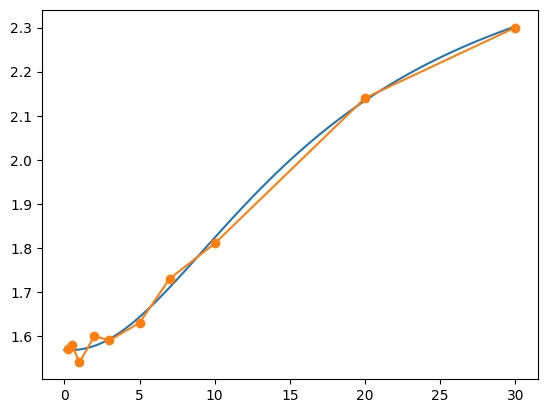

In [25]:
plt.plot(t_cont, fitted_curve)
plt.plot(t, y, '-o')

### Exercise 2.AE.C

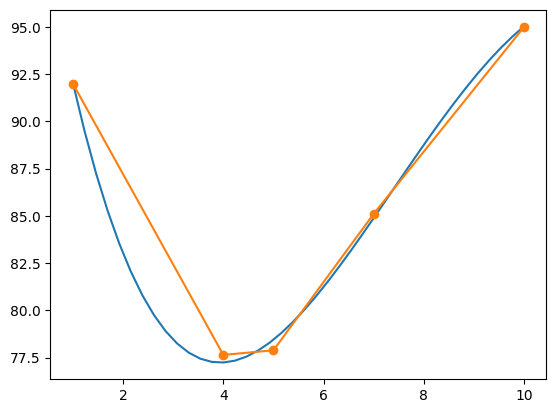

In [77]:
t = np.array([1,4,5,7,10])
p = np.array([91.9878, 77.6413, 77.8866, 85.1050, 94.9947])
curve, _ = calibrate_nss_ols(t, p)
t_eval = np.linspace(1, 10, 40)
fitted_curve = curve(t_eval)
plt.plot(t_eval, fitted_curve)
plt.plot(t, p, '-o')

### Modified and Macaulay Durations

In [26]:
# Base parameters.
N = 100
c = 0.05
T = 2
n = 2
ytm = [-0.02, -0.01, 0.01, 0.02, 0.03, 0.04 , 0.05]

In [42]:
def price_from_ytm(N:float, c:float, T:Union[int, float], n: int, y: float):
    '''Calculates a bond price based on the yield to maturity
    
    Parameters
    ----------
    N: float
        Face value of the bond
    c: float
        Coupon rate in a scale where 0 is 0% and 1 is 100%.
    T: float
        Time to maturity, commonly in years, but unit-agnostic
    n: int
        Payment frequency
    y: float
        Yield to maturity
    '''
    # Get total payments
    tot_payments = n * T
    # Get coupon pay times to get discount factors
    coupon_pay_times = [i * T/tot_payments for i in range(1, tot_payments +1)]
    # Define a simple helper function for discount that inherits most of the
    # arguments from the function

    def _discount(t:float):
        '''Calculates discount factor Z(0,t)'''
        power = - n * T
        return math.pow(1 - y / n, power)
    
    # Get all discount factors.
    discounts = [_discount(coup) for coup in coupon_pay_times]
    tot_dct = sum(discounts)
    # Get coupon component
    coupon = c * tot_dct / n
    # Get zero coupon component
    # This may not work if the bond does not mature at a coupon payment.
    # For this exercise, this should do the trick.
    zero_coup = discounts[-1]

    # Return total price
    return N * (coupon + zero_coup)

def macaulay(P:float, N:float, c:float, T:Union[int, float], n: int, y: float):
    '''Gets the macauly duration of a security

    Parameters
    ----------
    P: float
        Price of the bond
    N: float
        Face value of the bond
    c: float
        Coupon rate in a scale where 0 is 0% and 1 is 100%.
    T: numeric
        Time to maturity, commonly in years, but unit-agnostic
    n: int
        Payment frequency
    y: float
        Yield to maturity

    Returns
    -------
    d_mc: float
        Macaulay duration of the bond
    '''
    tot_payments = n * T
    
    # Get all weights for all coupon payments except maturity
    weights = [(N * c / n)/(P * math.pow(1 + y/n, i)) 
               for i in range(1, tot_payments)]
    # Get weight for maturity and append to weights
    last_weight = (N * (1 + c / n))/(P * math.pow(1 + y/n, tot_payments))
    weights.append(last_weight)

    #Get T_j
    coupon_pay_times = [i * T/tot_payments for i in range(1, tot_payments +1)]

    #Do the linear combination
    d_mc = 0
    for w, t in zip(weights, coupon_pay_times):
        d_mc += w * t

    return d_mc

def modified_duration(d_mc:float, y:float, n:int):
    '''Calculates the modified duration from a macaulay duration

    Parameters
    ----------
    d_mc: float
        Macaulay duration
    y: float
        Yield to maturity
    n: int
        Payment frequency

    Returns
    -------
    d_m: float
        Modified duration
    '''
    return d_mc / (1 + y / n)

In [71]:
# Test run for all functions
p = price_from_ytm(N, c, T, n, 0.25)
d_mc = macaulay(p, N, c, T, n, 0.25)
d_m = modified_duration(d_mc, 0.25, n)
print(f"Price: {p}, Macaulay Duration: {d_mc}, Modified Duration: {d_m}")

Price: 187.65514369012914, Macaulay Duration: 0.7124806320719625, Modified Duration: 0.6333161173973001


In [72]:
d_mc

0.7124806320719625

In [74]:
macaulay(p,N, 1, T,n,0.25)

1.6076927567210166

In [51]:
#Loop for storing plots data
#Using list comprehension in a dict into pandas data frame
final_data = {
    'y': [y for y in ytm],
    'price': [price_from_ytm(N, c, T, n, y) for y in ytm],
}
final_data['macaulay_d'] = [macaulay(p, N, c, T, n, y) for p, y in zip(final_data['price'], final_data['y'])]
final_data['modified_d'] = [modified_duration(d, y, n) for d, y in zip(final_data['macaulay_d'], final_data['y'])]

output_data = pd.DataFrame(final_data)
output_data

,y,price,macaulay_d,modified_d
0,-0.02,105.707838,2.091494,2.112621
1,-0.01,107.827227,2.010068,2.020169
2,0.01,112.227777,1.856617,1.847380
3,0.02,114.512239,1.784342,1.766676
4,0.03,116.855125,1.714877,1.689534
5,0.04,119.258236,1.648108,1.615792
6,0.05,121.723441,1.583928,1.545296


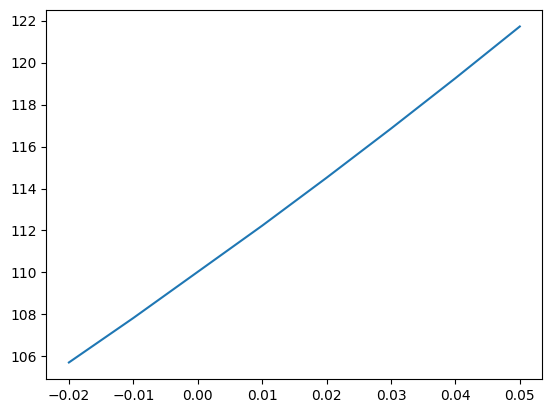

In [54]:
plt.figure()
plt.plot(final_data['y'], final_data['price'])

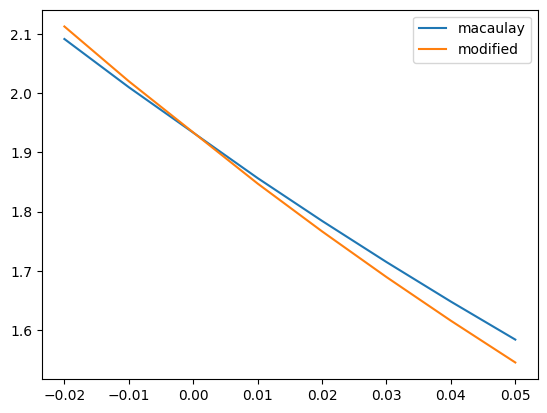

In [55]:
plt.figure()
plt.plot(final_data['y'], final_data['macaulay_d'], label='macaulay')
plt.plot(final_data['y'], final_data['modified_d'], label='modified')
plt.legend()

### All durations and prices for yields from -100% to 100%


In [59]:
#Loop for storing plots data
#Using list comprehension in a dict into pandas data frame
ytm2 = np.linspace(-1, 1, 400)
final_data = {
    'y': [y for y in ytm2],
    'price': [price_from_ytm(N, c, T, n, y) for y in ytm2],
}
final_data['macaulay_d'] = [macaulay(p, N, c, T, n, y) for p, y in zip(final_data['price'], final_data['y'])]
final_data['modified_d'] = [modified_duration(d, y, n) for d, y in zip(final_data['macaulay_d'], final_data['y'])]

output_data = pd.DataFrame(final_data)
output_data

,y,price,macaulay_d,modified_d
0,-1.000000,21.728395,152.910511,305.821023
1,-0.994987,21.874223,148.896395,296.307539
2,-0.989975,22.021276,145.000495,287.122568
3,-0.984962,22.169567,141.218892,278.253521
4,-0.979950,22.319108,137.547815,269.688345
...,...,...,...,...
395,0.979950,1625.648373,0.027493,0.018452
396,0.984962,1657.998593,0.026782,0.017944
397,0.989975,1691.157539,0.026087,0.017449
398,0.994987,1725.149593,0.025408,0.016967


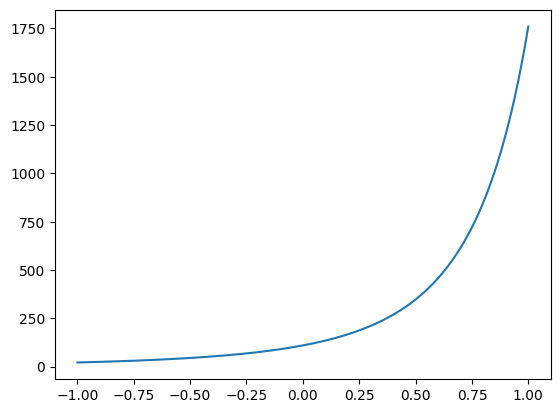

In [60]:
plt.figure()
plt.plot(final_data['y'], final_data['price'])

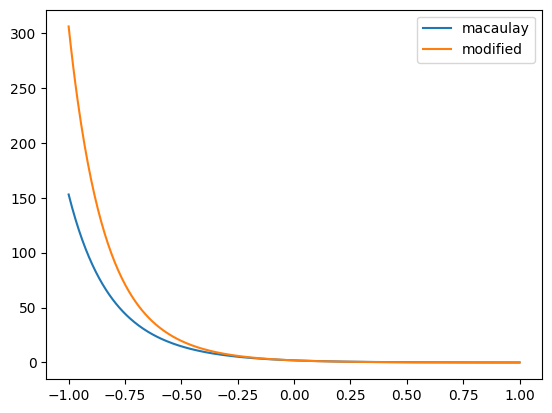

In [58]:
plt.figure()
plt.plot(final_data['y'], final_data['macaulay_d'], label='macaulay')
plt.plot(final_data['y'], final_data['modified_d'], label='modified')
plt.legend()

### Some simple extra analysis

In [61]:
import seaborn as sns

In [67]:
?sns.heatmap

<Axes: >

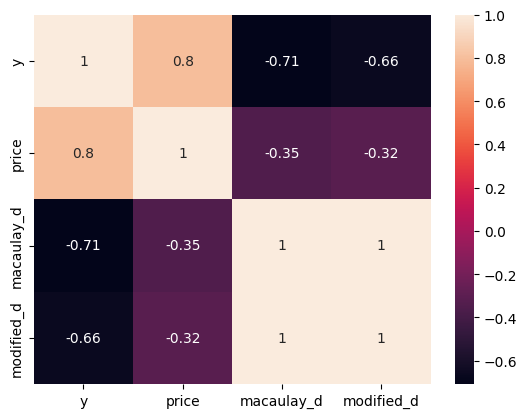

In [68]:
sns.heatmap(output_data.corr(), annot=True)

<Axes: >

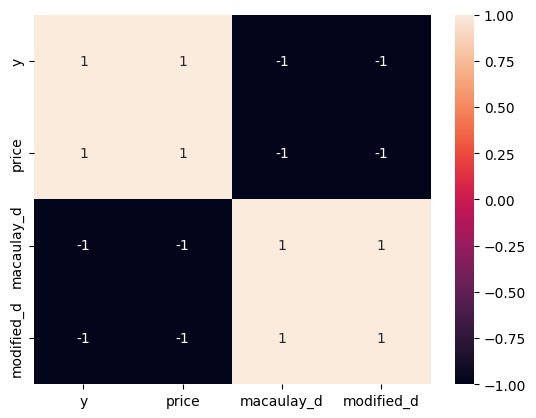

In [69]:
sns.heatmap(output_data.corr(method='spearman'),annot=True)

We can see that, as the yield increases, the bond price does to. We can also see that as these yields increase, both durations decrease. From the pearson correlation we see thattherelationship between both durations is not perfectly linear, nor is any other relation. However, we can confirm from spearman correlation that the monotonicity is perfectly correlated on both ends.


### Exercise 2.AE.1

In [78]:
coupons = [.05, .06, .07]

ps = [price_from_ytm(100, c, 10, 2, .06) for c in coupons]

In [79]:
ps

[275.83957419028553, 294.22887913630456, 312.61818408232364]

In [84]:
ps_imp = [[price_from_ytm(100, c, 10, 2, i/1000) for i in range(1,100)] for c in coupons]
ytm = [i/1000 for i in range(1,100)]

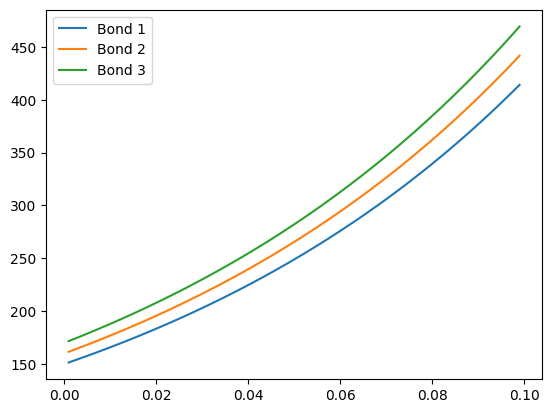

In [86]:
plt.figure()
plt.plot(ytm, ps_imp[0], label='Bond 1')
plt.plot(ytm, ps_imp[1], label='Bond 2')
plt.plot(ytm, ps_imp[2], label='Bond 3')
plt.legend()
plt.show()